In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect, select, join, text

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [9]:
# Explore Database
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [10]:
# Get a list of column names and types for Station
columns = inspector.get_columns('station')

for c in columns:
    print(c['name'], c["type"])


id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [11]:
# Get a list of column names and types for Measurement
columns = inspector.get_columns('measurement')

for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


# Exploratory Precipitation Analysis

In [12]:
# View Measurment Data
engine.execute('SELECT * FROM Measurement LIMIT 5').fetchall()

[(1, 'USC00519397', '2010-01-01', 0.08, 65.0),
 (2, 'USC00519397', '2010-01-02', 0.0, 63.0),
 (3, 'USC00519397', '2010-01-03', 0.0, 74.0),
 (4, 'USC00519397', '2010-01-04', 0.0, 76.0),
 (5, 'USC00519397', '2010-01-06', None, 73.0)]

In [13]:
# View Station Data
engine.execute('SELECT * FROM Station LIMIT 5').fetchall()

[(1, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 (2, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 (3, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0),
 (4, 'USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9),
 (5, 'USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6)]

In [14]:
# Find the most recent date in the data set.
recent = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print(recent)

('2017-08-23',)


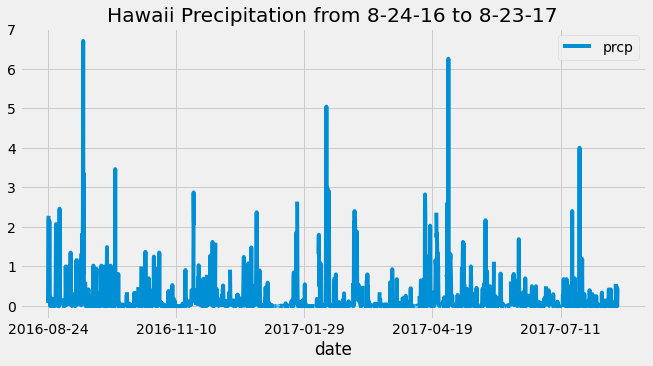

In [15]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 

# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
one_year = dt.date(2017, 8, 23) - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
precipitation_data = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date > one_year).\
    order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
precipitation_df = pd.DataFrame(precipitation_data)
precipitation_df.set_index('date', inplace=True)

# Sort the dataframe by date
precipitation_df_sorted = precipitation_df.sort_values("date", ascending=True)

# Use Pandas Plotting with Matplotlib to plot the data
axis = precipitation_df_sorted.plot(figsize=(10,5))
axis.set_title("Hawaii Precipitation from 8-24-16 to 8-23-17")
plt.show()

In [16]:
# Use Pandas to calcualte the summary statistics for the precipitation data
mean = precipitation_df_sorted['prcp'].mean()
median = precipitation_df_sorted['prcp'].median()
mode = precipitation_df_sorted['prcp'].mode()

mean_formatted = "{:.2f}".format(mean)
print(f'The mean is {mean_formatted}, the median is {median}, and the mode is {mode}')

The mean is 0.18, the median is 0.02, and the mode is 0    0.0
dtype: float64


In [17]:
# Determine if there are any potential outliers
quartiles = precipitation_df_sorted['prcp'].quantile([.25,.5,.75])
lowerq = quartiles[0.25]
upperq = quartiles[0.75]
iqr = upperq-lowerq
print(f"The lower quartile of precipitation is: {lowerq}")
print(f"The upper quartile of precipitation is: {upperq}")
print(f"The interquartile range of precipitation is: {iqr}")
print(f"The median of precipitation is: {quartiles[0.5]} ")
lower_bound = lowerq - (1.5*iqr)
upper_bound = upperq + (1.5*iqr)
print(f"Values below {lower_bound} could be outliers.")
print(f"Values above {upper_bound} could be outliers.")

The lower quartile of precipitation is: 0.0
The upper quartile of precipitation is: 0.13
The interquartile range of precipitation is: 0.13
The median of precipitation is: 0.02 
Values below -0.195 could be outliers.
Values above 0.325 could be outliers.


In [18]:
# Use describe to view summary stats of dataframe
precipitation_df_sorted.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [19]:
# Design a query to calculate the total number stations in the dataset
total_stations = session.query(Station.station).count()
print(f'There are a total of {total_stations} stations in the dataset')

There are a total of 9 stations in the dataset


In [20]:
# Design a query to find the most active stations (i.e. which stations have the most rows?).
active_stations = session.query(Measurement.station,func.count(Measurement.station).label('count')).\
    group_by(Measurement.station).order_by(text('count DESC')).all()

# List the stations and observation counts in descending order.
active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [21]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
temp_max = session.query(func.max(Measurement.tobs)).filter(Measurement.station == 'USC00519281').all()
temp_min = session.query(func.min(Measurement.tobs)).filter(Measurement.station == 'USC00519281').all()
temp_avg = session.query(func.avg(Measurement.tobs)).filter(Measurement.station == 'USC00519281').all()

print(f"The max temp is {[list[0] for list in temp_max]}, \
        the min temp is {[list[0] for list in temp_min]}, \
        and the average temp is {[list[0] for list in temp_avg]} \
        for station USC00519281")

The max temp is [85.0],         the min temp is [54.0],         and the average temp is [71.66378066378067]         for station USC00519281


In [22]:
# Using the most active station id 
# Query the last 12 months of temperature observation data for this station 

most_active_station_data = session.query(Measurement.date, Measurement.tobs).\
     filter(Measurement.date > one_year).\
     filter(Measurement.station == 'USC00519281').all()

# Save the query results as a Pandas DataFrame and set the index to the date column
most_active_df = pd.DataFrame(most_active_station_data)
most_active_df.set_index('date', inplace=True)
most_active_df

,tobs
date,
2016-08-24,77.0
2016-08-25,80.0
2016-08-26,80.0
2016-08-27,75.0
2016-08-28,73.0
...,...
2017-08-14,77.0
2017-08-15,77.0
2017-08-16,76.0


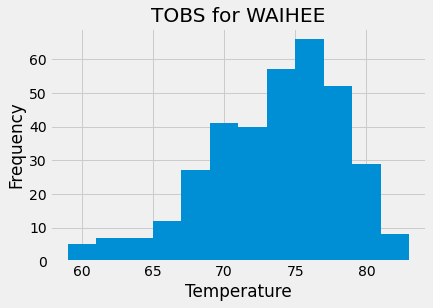

In [23]:
# Plot the results as a histogram
plt.hist(most_active_df, bins=12)
plt.title("TOBS for WAIHEE")
plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.show()

# Close session

In [24]:
# Close Session
session.close()